In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

import time

%matplotlib inline

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

april16_1996 = '1996-04-16T00:00:00.000Z'
april16_1996 = astropy.time.Time(april16_1996).jd
print(april16_1996)

months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']


2450083.5
2450189.5


# load SEM and SORCE

In [3]:
# normalized by heliocentric distance
SEM = Table.read("./CELIAS-SEM/SEMDailyData_norm.txt",format="ascii")
SEM = SEM[SEM['t_obs[JD]'] >= 2450190.]
print(SEM.colnames)

['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']


In [4]:
# from header:
# "Irradiances are reported at a mean solar distance of 1 AU and zero
#; relative line-of-sight velocity with respect to the Sun."
# so already normalized by heliocentric distance.
SORCE = Table.read("./SORCE/SORCEfluxTransmittedThroughEITFilters.txt", format="ascii")
print(SORCE.colnames)
print(SORCE['date[JD]'][0])
print(SORCE['date[JD]'][-1])

['date[JD]', 'transmitted_flux_171[arb.units]', 'transmitted_flux_171_unc[arb.units]', 'transmitted_flux_195[arb.units]', 'transmitted_flux_195_unc[arb.units]', 'transmitted_flux_284[arb.units]', 'transmitted_flux_284_unc[arb.units]', 'transmitted_flux_304[arb.units]', 'transmitted_flux_304_unc[arb.units]', 'transmitted_flux_sumEITBands[arb.units]', 'transmitted_flux_sumEITBands_unc[arb.units]', 'transmitted_flux_SEM1[arb.units]', 'transmitted_flux_SEM1_unc[arb.units]']
2452696.0
2458904.0


In [5]:
commonDates, SEMcommonDateIdxs, SORCEcommonDateIdxs = np.intersect1d(SEM['t_obs[JD]'], SORCE['date[JD]'],assume_unique=True, return_indices=True)
#print(SEM['t_obs[JD]'][SEMcommonDateIdxs])
#print(SORCE['date[JD]'][SORCEcommonDateIdxs])

In [6]:
def fluxRatio(f1, f2, u1, u2,normalize=True):
    """
    assume f1, f2 are defined on the same array of times and therefore have the same length
    """
    if normalize is True:
        med_f1 = np.median(f1[~np.isnan(f1)])
        med_f2 = np.median(f2[~np.isnan(f2)])
        unc_med_f1 = np.sqrt((np.pi/2) * np.sum(u1[~np.isnan(u1)]**2/len(u1[~np.isnan(u1)])))
        unc_med_f2 = np.sqrt((np.pi/2) * np.sum(u2[~np.isnan(u2)]**2/len(u2[~np.isnan(u2)])))
        ratio = (f1/med_f1)/(f2/med_f2)

        unc_ratio_sq = ((med_f2/(f2 * med_f1))**2 * u1**2) + (((f1*med_f2)/med_f1)**2 * (1/f2**2)**2 * u2**2) + (((f1*med_f2)/f2)**2 * (1/med_f1**2)**2 * unc_med_f1**2) + ((f1/(f2 * med_f1))**2 * unc_med_f2**2)
        

    else:
        ratio = f1/f2
        unc_ratio_sq = (u1/f2)**2 +  ((f1*u2)/f2**2)**2
        
    unc_ratio = np.sqrt(unc_ratio_sq)

    return ratio, unc_ratio

In [7]:
def least_squares_line(X,Y,Yerr):
    """
    Solve the normal equation B = (X.T*C.inv*X).inv*X.T*C.inv*Y
    Inputs:
    X = matrix of x values
    bOOT = integer best BIC polynomial OOT order
    Y = vector of y values
    Yerr = vector of yerr values
    Outputs:
    B = vector of model parameters that minimizes chi^2
    Bunc = analytic uncertainties on those parameters (see e.g. )
    """
    # least squares params
    Xmat = np.vander(X, 2)
    
    XTX = np.dot(Xmat.T, Xmat/Yerr[:, None]**2)
    
    B = np.linalg.solve(XTX, np.dot(Xmat.T, Y/Yerr**2))


    #uncertainties on least squares params
    N = len(Y)

    prefac = 1./(np.sum(1./Yerr**2)*np.sum(X**2/Yerr**2) - (np.sum(X/Yerr**2)**2))
    intercept_unc = np.sum( ((prefac/Yerr**2)*(np.sum(X**2/Yerr**2) - X*np.sum(X/Yerr**2)))**2 * Yerr**2)
    slope_unc =     np.sum( ((prefac/Yerr**2)*(-np.sum(X/Yerr**2)   + X*np.sum(1/Yerr**2)))**2 * Yerr**2)

    Bvar = np.array((slope_unc, intercept_unc))
    
    return B, Bvar

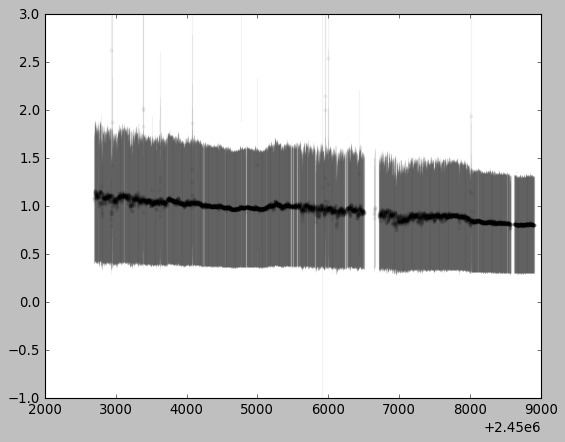

In [8]:
ratio,unc_ratio = fluxRatio(f1=SEM['firstOrderFlux[counts/s]'][SEMcommonDateIdxs],f2=SORCE['transmitted_flux_SEM1[arb.units]'][SORCEcommonDateIdxs],
                            u1=SEM['firstOrderFluxUnc[counts/s]'][SEMcommonDateIdxs],u2=SORCE['transmitted_flux_SEM1_unc[arb.units]'][SORCEcommonDateIdxs],
                           normalize=True)

nonan = (~np.isnan(ratio) & ~np.isnan(unc_ratio))
ratio = ratio[nonan]
unc_ratio = unc_ratio[nonan]
t_common = SEM['t_obs[JD]'][SEMcommonDateIdxs][nonan]

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(t_common,ratio,yerr=unc_ratio,elinewidth=1,capsize=0,color='k',marker='.',ls='None',alpha=0.05)
#ax.set_ylim(0.,0.75e13)
ax.set_ylim(-1,3)
plt.show()

In [9]:
B, Bvar = least_squares_line(X=t_common-t_common[0],Y=ratio,Yerr=unc_ratio)
m = B[0]
m_unc = Bvar[0]
b = B[1]
b_unc = Bvar[1]

In [10]:
print(B)
print(Bvar)

[-4.47207360e-05  1.09388072e+00]
[1.82149126e-11 2.67016211e-04]


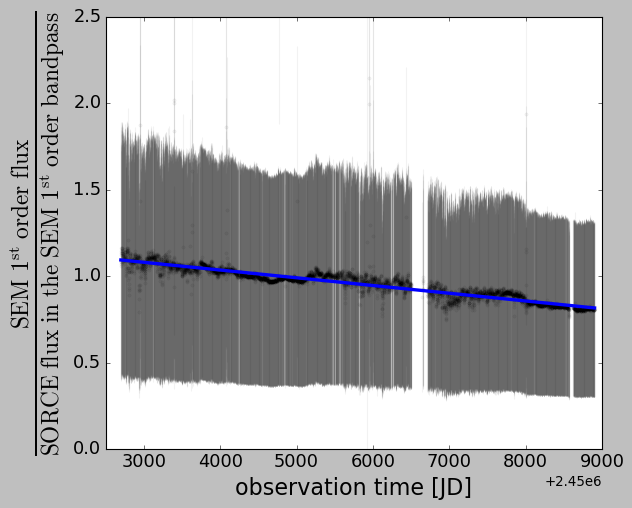

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(t_common,ratio,yerr=unc_ratio,elinewidth=1,capsize=0,color='k',marker='.',ls='None',alpha=0.05,zorder=1)
ax.plot(t_common, B[0]*(t_common-t_common[0]) + B[1], 'b-',lw=3,zorder=2)
ax.set_ylim(-0,2.5)
ax.set_xlim(2452500,2459000)
ax.set_ylabel(r"$\frac{\mathrm{SEM\ 1^{st}\ order\ flux}}{\mathrm{SORCE\ flux\ in\ the\ SEM\ 1^{st}\ order\ bandpass}}$", fontsize=30)
ax.set_xlabel("observation time [JD]",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.subplots_adjust(top=1.0)
plt.show()
#plt.savefig("./linear_fit_to_SEM_SORCE_ratio.pdf",bbox_inches='tight')

In [12]:
print(SEM.colnames)
print(SEM['firstOrderFlux[counts/s]'])
print(SEM['firstOrderFluxUnc[counts/s]'])

['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']
firstOrderFlux[counts/s]
------------------------
              169.376546
              170.388071
               171.16852
              172.360195
              172.272302
               173.90423
              173.022212
              170.080021
              168.250257
              167.412653
                     ...
              147.391623
              145.603719
              145.531629
              147.485863
              150.720607
              152.420982
              154.407764
              158.854474
              160.030065
              162.717866
Length = 10160 rows
firstOrderFluxUnc[counts/s]
---------------------------
                    0.33985
                   0.279177
                   0.357673
                   0.295067
                   0.327702
                   0.361487
                   0.644376
                 

In [27]:
ratio_wholebaseline = m*(SEM['t_obs[JD]']-t_common[0]) + b
SEM_corr = SEM['firstOrderFlux[counts/s]']/ratio_wholebaseline
SEM_unc_corr_sq = (SEM['firstOrderFluxUnc[counts/s]']/ratio_wholebaseline)**2 + ((SEM['firstOrderFlux[counts/s]'] * SEM['t_obs[JD]'])/ratio_wholebaseline**2)**2*m_unc**2 + (SEM['firstOrderFlux[counts/s]']/ratio_wholebaseline**2)**2*b_unc**2
SEM_unc_corr = np.sqrt(SEM_unc_corr_sq)

fig, axes = plt.subplots(2,1,figsize=(10,8))

for i, y in enumerate(np.arange(1996,2025)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd

    for ax in axes:
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=0.5,zorder=1,alpha=0.5)  
    axes[1].text(jan1_thisyear + 180., 65, "'"+str(y)[-2:],horizontalalignment='center',fontsize=12,backgroundcolor='None')


axes[0].errorbar(t_common,ratio,yerr=unc_ratio,elinewidth=1,capsize=0,color='k',marker='.',ls='None',alpha=0.05,zorder=1)
axes[0].plot(SEM['t_obs[JD]'], B[0]*(SEM['t_obs[JD]']-t_common[0]) + B[1], 'b-',lw=3,zorder=2)
axes[0].set_ylim(-0,2)
axes[0].set_xlim(2452500,2459000)
axes[0].set_ylabel(r"$\frac{\mathrm{SEM\ 1^{st}\ order\ flux}}{\mathrm{SORCE\ flux\ in\ the\ SEM\ 1^{st}\ order\ bandpass}}$", fontsize=30)
axes[0].set_xticklabels([])
axes[0].tick_params(axis='y', which='major', labelsize=16)

axes[1].errorbar(SEM['t_obs[JD]'], SEM['firstOrderFlux[counts/s]'],yerr=SEM['firstOrderFluxUnc[counts/s]'],color='k',marker='.',elinewidth=1,capsize=0,alpha=0.05,ls='None')
axes[1].errorbar(SEM['t_obs[JD]'], SEM_corr,yerr=SEM_unc_corr,color='b',marker='.',elinewidth=1,capsize=0,alpha=0.05,ls='None')
axes[1].errorbar(2470000,0,1,color='k',marker='.',elinewidth=1,capsize=0,alpha=1,ls='None',label='uncorrected')
axes[1].errorbar(2470000,0,1,color='b',marker='.',elinewidth=1,capsize=0,alpha=1,ls='None',label='corrected')
#axes[1].plot(SEM['t_obs[JD]'], ratio_wholebaseline, 'b-',lw=3)
axes[1].set_ylabel(r"$\mathrm{SEM\ 1^{st}\ order\ flux\ [counts/s]}$", fontsize=30)
#axes[1].set_xlabel("observation time [JD]",fontsize=20)
axes[1].legend(loc='upper right',frameon=False)

axes[1].tick_params(axis='both', which='major', labelsize=16)
for ax in axes:
    ax.set_xlim(2450000,2460500)
axes[1].set_ylim(75,325)
axes[1].set_xticks([])
plt.subplots_adjust(top=1.5,hspace=0.05)
#plt.show()
plt.savefig("SEM_1storder_correction.pdf",bbox_inches='tight')

In [104]:
corr_SEMdata = np.vstack((SEM['t_obs[JD]'].T,SEM_corr.T,SEM_unc_corr.T)).T
print(np.shape(corr_SEMdata))

np.savetxt("./CELIAS-SEM/SEMDailyData_norm_1storderDegradationCorrected.txt",corr_SEMdata,fmt="%f", header="t_obs[JD] firstOrderFlux[counts/s] firstOrderFluxUnc[counts/s]")


(10160, 3)


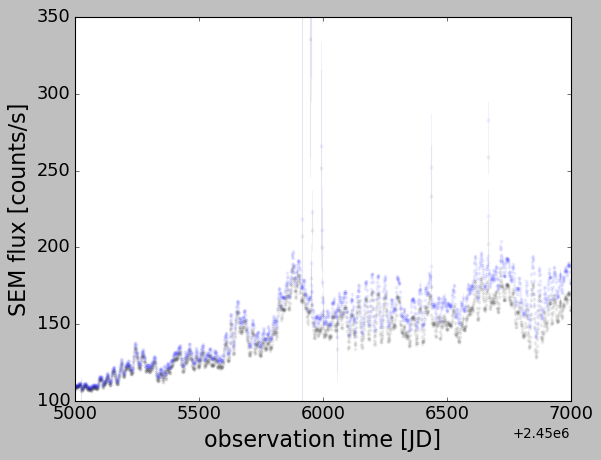

In [153]:

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(SEM['t_obs[JD]'], SEM['firstOrderFlux[counts/s]'],yerr=SEM['firstOrderFluxUnc[counts/s]'],color='k',marker='.',elinewidth=1,capsize=0,alpha=0.05,ls='None')
ax.errorbar(SEM['t_obs[JD]'], SEM_corr,yerr=SEM_unc_corr,color='b',marker='.',elinewidth=1,capsize=0,alpha=0.05,ls='None')
#ax.plot(SEM['t_obs[JD]'], ratio_wholebaseline, 'b-',lw=3)
ax.set_ylabel("SEM flux [counts/s]", fontsize=20)
ax.set_xlabel("observation time [JD]",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim(2455000,2457000)
ax.set_ylim(100,350)
#ax.axvline(2455990, color='b')

plt.show()
